Código com base no repositório [Bert_HateSpeech_Classification](https://github.com/cewebbr/Bert_HateSpeech_Classification) de Diogo Cortiz.


Validation for Fortuna dataset, trained with Fortuna dataset:
- Accuracy: 0.91
- F1 Score: 0.907730557656237
- Recall: 0.907981220657277
- Precision:  0.9075677970279258
- True Negative:  1351
- False Positive:  91
- False Negative:  105
- True Positive:  583

Validation for all datasets, trained with Fortuna dataset:
- Accuracy: 0.73
- F1 Score: 0.7279704228826497
- Recall: 0.73125
- Precision:  0.755912923636288
- True Negative:  8421
- False Positive:  1298
- False Negative:  4249
- True Positive:  6672

Validation for all datasets, trained with all datasets:
- Accuracy: 0.92
- F1 Score: 0.9236011371917673
- Recall: 0.9236918604651163
- Precision:  0.9239831632557589
- True Negative:  8767
- False Positive:  952
- False Negative:  623
- True Positive:  10298

In [1]:
## PARA RODAR NO GOOGLE COLAB
colab = True

In [10]:
import torch
from transformers import BertModel, BertForMaskedLM, PreTrainedTokenizer
from tokenizers import BertWordPieceTokenizer
import numpy as np
import time
import datetime
import pandas as pd

In [14]:
if colab:
  # Tell PyTorch to use the GPU.
  device = torch.device("cuda")

  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = '/content/drive/MyDrive/_PUC/concat_binary_df.parquet'

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    data_path = ''

if not os.path.exists('vocab.txt'):
  !pip install wget
  import wget
  wget.download("https://huggingface.co/neuralmind/bert-base-portuguese-cased/raw/main/vocab.txt")

vocab_path = 'vocab.txt'
df = pd.read_parquet(data_path)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
df.head(5)

,text,label,source
0,Mais um lixo,1,HateBR
1,Essa nao tem vergonha na cara!!,1,HateBR
2,Essa mulher é doente.pilantra!,1,HateBR
3,Comunista safada...,1,HateBR
4,Vagabunda. Comunista. Mentirosa. O povo chilen...,1,HateBR


## FUNÇÕES

In [5]:
def create_tokenizer_and_tokenize(sentencas, max_length=60):
    """
    Cria o tokenizer BertWordPieceTokenizer e tokeniza as sentenças em batch.
    Retorna o tokenizer, os ids, a attention_mask e o output bruto.
    """
    from tokenizers import BertWordPieceTokenizer

    # Cria o tokenizer
    tokenizer = BertWordPieceTokenizer(vocab_path, lowercase=False, strip_accents=False)

    # Configura truncamento e padding
    tokenizer.enable_truncation(max_length=max_length)
    tokenizer.enable_padding()

    # Tokeniza em batch
    output = tokenizer.encode_batch(sentencas)

    # Extrai ids e attention_mask
    ids = [x.ids for x in output]
    attention_mask = [x.attention_mask for x in output]

    print(len(ids))
    print(len(attention_mask))
    print(output[0])
    print(output[0].tokens)

    return tokenizer, ids, attention_mask, output

def create_prediction_dataloader(tokenizer, sentencas, labels, batch_size=32, max_length=100):
    # Configura o tokenizer
    tokenizer.enable_truncation(max_length=max_length)
    tokenizer.enable_padding()

    # Tokeniza em batch
    output = tokenizer.encode_batch(sentencas)

    # Extrai ids e masks
    ids = [x.ids for x in output]
    attention_mask = [x.attention_mask for x in output]

    # Converte para tensores
    prediction_input = torch.tensor(ids)
    prediction_mask = torch.tensor(attention_mask)
    prediction_labels = torch.tensor(labels)

    # Cria o DataLoader
    prediction_data = TensorDataset(prediction_input, prediction_mask, prediction_labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

    return prediction_dataloader

# FUNÇÃO  QUE CALCULA A ACURÁCIA DO MODELO (PREDIÇÕES vs LABELS)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# FUNÇÃO QUE FORMATA O HORÁRIO
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



"""OPCIONAL: Pode ativar um debbug para entender melhor o que acontece"""

In [6]:

import logging
logging.basicConfig(level=logging.INFO)


## Formatando a Entrada e Criando os Tokens e IDS

Agora chegou a hora de criarmos os tokens para que depois eles possam ser mapeados para os index do vocabulário.<Br>
Para isso, utilizaremos o BertTokenizer, que já importamos anteriormente. Utilizaremos a versão 'bert-based-unscased' (inglês).<br>
Antes disso, no entanto, precisamos formatar a entrada para respeitar os requisitos de entrada do Bert, que são os seguintes:


1.   Adicionar tokens especiais no início e no fim de cada sentença ([CLS] para o início de uma sentença de classificação / [SEP] para indicar o fim de uma sentença.

<img src="http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png" alt="placeholder" width="50%" height="50%">

2. Precisamos fazer o Pad e Truncate para que todas as senteças tenham o mesmo tamanho de entrada (máximo de 512 tokens).

3. Diferenciar o que são tokens reais dos token de padding, criando um "attention mask".
<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" alt="placeholder" width="50%" height="50%">

## Entendendo o Tokenizer<br>
O modelo do Google tem um vocabulário de 30.000 tokens com aprox 768 dimensões cada (embeedings).<br>
Os Tokens podem representar palavras completas (mas não todas) <br>
Os Tokens podem representar sub-palavras de palavras desconhecidas (as subwords são iniciadas com ##. Reparem que a palavra Diogo não existe no vocabulário. Ela é quebrada em duas subwords: Dio + ##go. Atenção: O token go é diferente do ##go) <oov><br>
Os Tokens podem representar caracteres e marcações especiais:<br>
[PAD]: Padding<br>
[UNK]:Unknow<br>
[CLS]: Classificação<br>
[SEP]: Separação das sentenças<br>
[MASK]: Máscara para a palavra<br>

In [12]:
import os
# USA O MODULO TOKENIZER DO HUGGINFACE
from tokenizers import (ByteLevelBPETokenizer,
                            SentencePieceBPETokenizer,
                            BertWordPieceTokenizer)

In [16]:
labels = df['label'].values
sentencas = [sentenca.lower() for sentenca in df['text'].values]
tokenizer, ids, attention_mask, output = create_tokenizer_and_tokenize(sentencas=sentencas)

55035
55035
Encoding(num_tokens=60, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', 'mais', 'um', 'lixo', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


## Dividindo o Dataset em Treinamento e Validação

Vamos usar a ferramenta do ScikitLearn para nos ajudar neste processo. Vamos dividir o dataset em 80% para treinamento e 20% para a validação

In [17]:
from sklearn.model_selection import train_test_split

#USAR O MESMO RANDON_STATE PARA NAO TROCAR OS INPUTS DE SUAS MÁSCARAS
train_input, validation_input, train_labels, validation_labels = train_test_split(ids, labels, random_state=2018, test_size=0.2)
train_mask, validation_mask, _, _ = train_test_split(attention_mask, labels, random_state=2018, test_size=0.2)

#COMPARANDO A PRIMEIRA LINHA DE TREINAMENTO COM A MASCARA
print(train_input[0])
print(train_mask[0])


[101, 137, 727, 140, 17080, 2639, 160, 22295, 22287, 1273, 1940, 126, 1354, 22290, 268, 1396, 22331, 22331, 22331, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Criando os tensores (Pytorch Data Type)
Os modelos do PyTorch esperam de entrada o tipo tensor, então precisamos converter o nosso dataset de Numpy Array para tensores.

In [18]:
train_input_tensor = torch.tensor(train_input)
validation_input_tensor = torch.tensor(validation_input)

train_labels_tensor = torch.tensor(train_labels)
validation_labels_tensor = torch.tensor(validation_labels)

train_mask_tensor = torch.tensor(train_mask)
validation_mask_tensor= torch.tensor(validation_mask)

Uma ação adicional é usar o torch DataLoader, que cria um "iterator". Diferente de um for, o iterador não sobe todo o dataset não precisa ser carregado todo na memória (ajuda no treinamento)

In [19]:

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#É PRECISO ESPECIFICAR O TAMANHO DO BATCH, PARA O BERT OS AUTORES RECOMENDAM 16 OU 32
batch_size = 32

#CRIA OS DATALOADERS PARA O CONJUNTO DE TREINAMENTO
train_data = TensorDataset(train_input_tensor, train_mask_tensor, train_labels_tensor)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#CRIA OS DATALOADRES PARA O CONJUNTO DE VALIDAÇÃO
validation_data = TensorDataset(validation_input_tensor, validation_mask_tensor, validation_labels_tensor)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Treinando o modelo
O Bert oferece um modelo pré-treinando a qual só precisamos fazer fine-tune para a tarefas que desejamos. O huggingface disponibiza não só o modelo pré-treinado mas também interfaces para nossas tarefas específicas. Algumas disponíveis são:


*   BertMode
*   BertForMaskedLM
*   BertForNextSentencePrediction
*   BertForSequenceClassification (vamos usar este)
*   BertForTokenClassification
*   BertForQuestionAnsering

O BertForSequenceClassification basicamente é a implementação do modelo Bert com a adição de uma camada de FFN para classificação. Lembre-se que o hugging face disponibilizou diversas versões de modelo pré-treinanda (base, large, multilanugage). Você pode escolher a que for melhor para o seu propósito. Neste caso, vamos utilizar a versão multilingual por contemplar o português.

In [20]:
#IMPORTA O BERT E O OTIMIZADOR ADAM
from transformers import BertForSequenceClassification, BertConfig, BertModel

#CRIA O MODELO BERT PRETREINADO COM UMA CAMADA DE CLASSIFICAÇÃO NO TOPO
model = BertForSequenceClassification.from_pretrained(
    'neuralmind/bert-base-portuguese-cased',
    num_labels = 2, # NUMERO DE CLASSES (NO CASO BINÁRIA: ACEITÁVEL OU NÃO. PODE TER MAIS PARA MULTICLASSE)
    output_attentions = True, # SE O MODELO DEVE EXPORTAR OS PESOS DAS ATENÇÕES
    output_hidden_states = True, # SE O MODELO DEVE EXPORTAR OS HIDDEN STATES (PODE SER INTERESSANTE PARA ESTUDAR EMBEDDINGS)
)

# DIZ AO MODELO PARA USAR GPU
if torch.cuda.is_available():
  model.cuda()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



## Exibindo parâmetros do modelo
Uma curiosidade disponibilizada em (https://mccormickml.com/2019/07/22/BERT-fine-tuning/) <br>
É possível mostrar os parâmetro do modelo:
<br>
*   A camada de embeddings
*   A primeira das 12 camadas de transformers
*   A camada de saída (output)

A execução do trecho abaixo é optativa.

In [21]:

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (29794, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## Otimizador

Carregamos o modelo, agora precisamos criar o Otimizador Adam. Os autores recomendam os seguintres valores:
*   Batch Size: 16, 32 (Lembre-se que usamos 32 no Dataloader)
*   Learning Rate (Adam):  5e-5, 3e-5, 2e-5 (vamos usar 2e-5)
*   Numero de épocas (Quantas vezes TODO o dataset é treinado):  2,3,4 (utilizaremos 4):

In [22]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


## Learning Rate Scheduler
Em redes neurais é útil diminuir a taxa de aprendizado (learning rate) conforme as épocas vão aumentando para que possamos evitar que o modelo entre em um estado "caótico" com taxas grandes ou o "falso míninmo" com taxas pequenas. A ideia é ir ajustando conforme as épocas vão passando.

In [23]:
#ESTA CLASSE FARÁ O AGENDAMENTO
from transformers import get_linear_schedule_with_warmup

epochs = 4 #QUANTIDADE DE ÉPOCAS

#PARA CALCULAR A QUANTIDADE DE PASSOS É A QTD DE BATCHS * ÉPOCAS
total_steps = epochs * len(train_dataloader)

#CRIANDO O AGENDADOR
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, #VALOR PADRÃO
                                            num_training_steps = total_steps)

## Loop de Treinamento
Não é só chamar alguma função para treinar o modelo. Precisamos criar um loop que se repita a quantidade de épocas especificadas executando as atividades abaixo. A cada passagem, também faremos uma avaliação do modelo:

Loop de treinamento
*   Desempacotar os dados de entrada e os labels
*   Carregar os dados para a GPU
*   Limpar os gradientes calculados na passagem anterior (no pytorch os gradientes são acumulados por padrão. pode ser útil para RNN, mas não no caso de transformers.
* Forward Pass (Passar os dados pela rede)
* Backward Pass (backpropagation)
* Pedir para a rede atualizar os parâmetros (optimizer.step())
* Monitar as variáveis para saber o progresso

Loop de avaliação
* Desempacotar os dados de entrada e os labels
* Carregar os dados para a GPU
* Forward Pass (Passar os dados pela rede)
* Computar a perda na nossa validação e monitorar as variáveis para saber o progresso.

**Antes, vamos criar duas funções de ajuda. Uma para calcular a acurácia do modelo e outra para formatar o horário**:

In [24]:
"""**AGORA VEM O LOOP DE TREINAMENTO :)**"""

import random

# PRIMEIRO PRECISAMOS GARANTIR A REPRODUTIBILIDADE
# USANDO OS SEEDS DO PYTORCH, GARANTIMOS QUE OS VALORES SERÃO INICIADOS DA MESMA FORMA
# VAMOS SETAR O MESMO VALOR EM DIFERENTES LUGARES

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# CRIANDO UMA LISTA QUE IRÁ ARMZENAR LOSS AO FIM DE CADA ÉPOCA
loss_values = []

# CRIANDO O LOOP DAS ÉPOCAS
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # MEDIR QUANTO TEMPO UMA ÉPOCA LEVA
    t0 = time.time()

    # RESETANDO O LOSS PARA ESTA ÉPOCA
    total_loss = 0

    #COLOCANDO O MODELO NO MODO DE TREINAMENTO
    #ESSE COMANDO NÃO CHAMA O TREINAMENTO, APENAS AVISA O MODELO PARA FAZER AJUSTES DE DROPOUTS
    model.train()
    device = torch.device("cuda")

    # UM LOOP PARA CADA BATCH  DENTRO DA ÉPOCA
    for step, batch in enumerate(train_dataloader):
        # PRECISAMOS DESPEMPACOTAR O BATCH E CARREGAR NA GPU
        # BATCH CONTEM TRÊS TENSORES
        #   [0]: ID DE INPUT
        #   [1]: ATTENTION MASKS
        #   [2]: LABELS
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #PRECISAMOS LIMPAR O GRADIENTE ANTES DE BACKPROP
        #PYTORCH NAO FAZ ISSO AUTOMÁTICO
        model.zero_grad()

        #AGORA VAMOS FAZER UMA PASSAGEM (FORWARD PASS)
        #O RESULTADO SERÁ LOSS (NÃO SERÁ A PREDIÇÃO PQ PASSAMOS OS LABELS)
        outputs = model(b_input_ids,
                    token_type_ids=None, #USADO QUANDO É NEXT SEQUENCE
                    attention_mask=b_input_mask,
                    labels=b_labels)

        #O MODELO RETORNA UMA TUPLA.
        #VAMOS PEGAR O VALOR DA TUPLA
        loss = outputs[0]
        hidden_state = outputs[2]


        # VAMOS ARMAZENAR O HIDDEN STATE E ATENÇÃO TB



        #VAMOS ACUMULAR O VALOR NO TOTAL DE LOSS DA ÉPOCA
        # .item() RETORNA UM VALOR PYTHON DE UM TENSOR
        total_loss += loss.item()

        #AGORA VAMOS FAZER O BACKWARD PARA CALCULAR O GRADIENTE
        loss.backward()

        # PASSO NECESSÁRIO
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # O OTIMIZADOR VAI ATUALIZAR OS PARAMETROS COM BASE NO GRADIENTE
        optimizer.step()

        # ATUALIZANDO O LEARNING RATE
        scheduler.step()

    # APOS TODOS OS BATCH DE UMA EPOCA
    # CACLULA AVERAGE LOSS COM BASE NO TREINAMENTO (TAMANHO DO DATASET)

    avg_train_loss = total_loss / len(train_dataloader)

    #ARMAZENA O LOSS NA LISTA (PARA DEPOIS SER PLOTADO NO GRAFICO)
    loss_values.append(avg_train_loss)

    # DENTRO DE CADA ÉPOCA TAMBÉM VAMOS RODAR UMA AVALIAÇÃO
    print("Running Validation...")
    t0 = time.time()

    # COLOCANDO O MODELO NO MODO DE AVALIAÇÃO (SAINDO DO MODULO DE TREINAMENTO)
    model.eval()

    # CRIANDO VARIÁVEIS DE MONITORAMENTO
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # LOOP PARA AVALIAR CADA BATCH DE TREINAMENTO
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # PEDE AO MODELO PARA NAO COMPUTAR GRADIENTES (É VALIDAÇÃO, NÃO TREINAMENTO)
        with torch.no_grad():
          # FORWARD PASS PARA CALCULAR OS LOGITS DA PREDIÇÃO
          outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # O RESULTADO DO MODELO AGORA NÃO SERÁ LOSS
        # SERÁ 'LOGITS', VALOR DE SAIDA ANTES DE UMA FUNÇÃO DE ATIVAÇÃO (SOFTMAX POR EXEMPLO)
        # COMO É UMA CLASSIFICAÇÃO BINÁRIA, SÓ OS LOGITS SERVEM
        # DEPENDENDO DO MODELO SERIA NECESSÁRIO UM SOFTMAX
        logits = outputs[0]

        # MOVER OS LOGITS E OS LABELS PARA A CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #CALCULAR ACURÁCIA CHAMANDO A FUNÇÃO QUE CRIAMOS ANTERIORMENTE
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # ACUMULAR O TOTAL DA ACURÁCIA
        eval_accuracy += tmp_eval_accuracy

        # TRACKEAR O NUMERO DE BATCHS
        nb_eval_steps +=1

    # EXIBINDO DADOS FINAIS
    print("  Acurácia: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Tempo de Validação: {:}".format(format_time(time.time() - t0)))

#FIM DAS EPOCAS
print("FIM DO TREINAMENTO")



======== Epoch 1 / 4 ========
Training...


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Running Validation...
  Acurácia: 0.82
  Tempo de Validação: 0:00:36

======== Epoch 2 / 4 ========
Training...
Running Validation...
  Acurácia: 0.82
  Tempo de Validação: 0:00:36

======== Epoch 3 / 4 ========
Training...
Running Validation...
  Acurácia: 0.82
  Tempo de Validação: 0:00:36

======== Epoch 4 / 4 ========
Training...
Running Validation...
  Acurácia: 0.82
  Tempo de Validação: 0:00:36
FIM DO TREINAMENTO



## Mostrando o gráfico LOSS por época

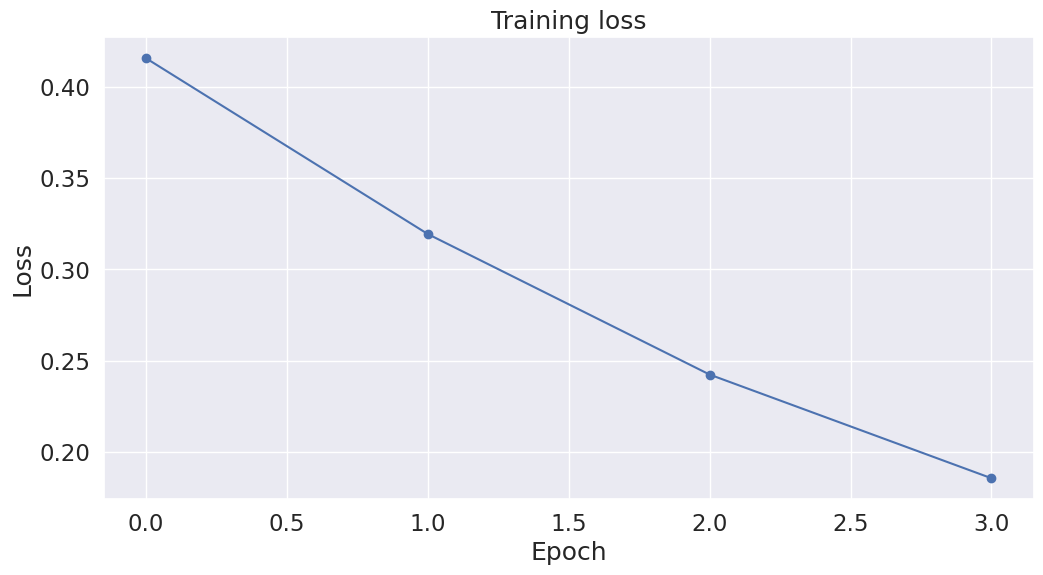

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Executando e Testando o modelo

Agora que o modelo está treinado, podemos executá-lo. Nesta seção vamos fazer alguns testes. O primeiro ponto é preparar os dados (assim como fizemos na fase de treinamento), mas desta vez não precisamos dos labels.

In [26]:
# FUNÇÃO QUE VALIDA O MODELO
def Validar_Modelo(prediction_dataloader, batch_size):
  #ARMAZENAR RESULTADOS
  resultado_predicoes = []
  resultados_esperados = []
  falsos_positivos = []
  falsos_negativos = []
  verdadeiros_positivos = []
  verdadeiros_negativos =[]
  nb_eval_steps = 0
  eval_accuracy = 0
  tmp_eval_accuracy = 0
  for batch in prediction_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    # PEDE AO MODELO PARA NAO COMPUTAR GRADIENTES (É VALIDAÇÃO, NÃO TREINAMENTO)
    with torch.no_grad():
      # FORWARD PASS PARA CALCULAR OS LOGITS DA PREDIÇÃO
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # O RESULTADO DO MODELO AGORA NÃO SERÁ LOSS
    # SERÁ 'LOGITS', VALOR DE SAIDA ANTES DE UMA FUNÇÃO DE ATIVAÇÃO (SOFTMAX POR EXEMPLO)
    # COMO É UMA CLASSIFICAÇÃO BINÁRIA, SÓ OS LOGITS SERVEM
    # DEPENDENDO DO MODELO SERIA NECESSÁRIO UM SOFTMAX
    # TAMBÉM É POSSIVEL PEGAR A ATENÇÃO E OS HIDDEN STATES
    logits = outputs[0]
    attention=outputs[-1]
    all_hidden_state = outputs[-2]

    # MOVER OS LOGITS E OS LABELS PARA A CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    reconstruct_input_id = b_input_ids.to('cpu').numpy()

    # LOOP PARA VISUALIZAR CADA SETENÇA
    for logit, label, inputs, att in zip(logits, label_ids, reconstruct_input_id, attention):
      resultado_predicoes.append(np.argmax(logit))
      resultados_esperados.append(label)
      # LOOP PARA IDENTIFICAR FALSOS POSITIVIOS, FALSOS NEGATIVOS e CORRETOS
      if (label != np.argmax(logit)):
        if (label == 1 and np.argmax(logit) == 0):
          falsos_negativos.append(inputs)
          #captum(inputs,label,logit, "fn")
        elif(label == 0 and np.argmax(logit) == 1):
          falsos_positivos.append(inputs)
          #captum(inputs,label,logit, "fp")
      else:
        if (label == 1 and np.argmax(logit) == 1):
          verdadeiros_positivos.append(inputs)
          #captum(inputs,label,logit, "tp")
        elif (label == 0 and np.argmax(logit) == 0):
          verdadeiros_negativos.append(inputs)
          #captum(inputs,label,logit, "tn")

    #CALCULAR ACURÁCIA CHAMANDO A FUNÇÃO QUE CRIAMOS ANTERIORMENTE
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    # ACUMULAR O TOTAL DA ACURÁCIA
    eval_accuracy += tmp_eval_accuracy

    # TRACKEAR O NUMERO DE BATCHS
    nb_eval_steps +=1
    #wait = input("PRESS ENTER TO CONTINUE.")

  # RELATÓRIO FINAL
  print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))

  from sklearn.metrics import accuracy_score
  print("Accuracia: ", accuracy_score(resultados_esperados, resultado_predicoes))

  from sklearn.metrics import f1_score
  print("F1 Score:", f1_score(resultados_esperados, resultado_predicoes, average='weighted'))

  from sklearn.metrics import recall_score
  print("Recall:", recall_score(resultados_esperados, resultado_predicoes, average='weighted'))

  from sklearn.metrics import precision_score
  print("Precision: ", precision_score(resultados_esperados, resultado_predicoes, average='weighted'))

  #listar_falsospositivos(falsos_positivos)
  #attrib2csv(attrib_falsospositivo, "falsos_positivos.csv")
  #attrib2csv(attrib_falsosnegativos, "falsos_negativos.csv")
  #attrib2csv(attrib_verdadeirospositivos, "verdadeiros_positivos.csv")
  #attrib2csv(attrib_verdadeironegativos, "verdadeiros_negativos.csv")

  from sklearn.metrics import confusion_matrix
  tn, fp, fn, tp = confusion_matrix(resultados_esperados, resultado_predicoes).ravel()
  print ("True Negative: ", tn)
  print ("False Positive: ", fp)
  print ("False Negative: ", fn)
  print ("True Positive: ", tp)


In [28]:
prediction_dataloader = create_prediction_dataloader(tokenizer=tokenizer, sentencas=sentencas, labels=labels)
Validar_Modelo(prediction_dataloader, batch_size)

  Accuracy: 0.92
Accuracia:  0.9236918604651163
F1 Score: 0.9236011371917673
Recall: 0.9236918604651163
Precision:  0.9239831632557589
True Negative:  8767
False Positive:  952
False Negative:  623
True Positive:  10298


## Salvar pesos do modelo

In [31]:
# Specify a directory to save the model
output_dir = '/content/drive/My Drive/_PUC/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_model(output_dir)

Saving model to /content/drive/My Drive/_PUC/


['/content/drive/My Drive/_PUC/vocab.txt']

# Testing on whole corpus of data


In [ ]:
import torch
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np

In [ ]:
from transformers import BertForSequenceClassification

# 1. Recreate the model architecture (must match training)
model = BertForSequenceClassification.from_pretrained(
    'neuralmind/bert-base-portuguese-cased',
    num_labels=2,
    output_attentions=True,
    output_hidden_states=True,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Import full binary dataset

In [ ]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive')

  df = pd.read_parquet('/content/drive/MyDrive/_PUC/concat_binary_df.parquet')

  state_dict = torch.load('/content/drive/MyDrive/_PUC/2025-04-06-bert-v1.pkl', map_location='cuda')
  model.load_state_dict(state_dict)

  if not os.path.exists('vocab.txt'):
    !pip install wget
    import wget
    wget.download("https://huggingface.co/neuralmind/bert-base-portuguese-cased/raw/main/vocab.txt")

else:
  df = pd.read_parquet('../../data/processed_data/concat_binary_df.parquet')

  state_dict = torch.load('../../ig-models/2025-04-06-bert-v1.pkl', map_location='cpu')
  model.load_state_dict(state_dict)

vocab_path = 'vocab.txt'
model.to(device)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,label,source
0,Mais um lixo,1,HateBR
1,Essa nao tem vergonha na cara!!,1,HateBR
2,Essa mulher é doente.pilantra!,1,HateBR
3,Comunista safada...,1,HateBR
4,Vagabunda. Comunista. Mentirosa. O povo chilen...,1,HateBR


In [ ]:
model.eval()  # Set to evaluation mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Create tokenizer

In [ ]:
labels = df['label'].values
sentencas = [sentenca.lower() for sentenca in df['text'].values]
tokenizer, ids, attention_mask, output = create_tokenizer_and_tokenize(sentencas, max_length=60)

55035
55035
Encoding(num_tokens=60, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', 'mais', 'um', 'lixo', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


## Prediction dataloader

In [ ]:
prediction_dataloader = create_prediction_dataloader(tokenizer, sentencas, labels)

## Validate

In [ ]:
Validar_Modelo(prediction_dataloader, batch_size=32)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


  Accuracy: 0.73
Accuracia:  0.73125
F1 Score: 0.7279704228826497
Recall: 0.73125
Precision:  0.755912923636288
True Negative:  8421
False Positive:  1298
False Negative:  4249
True Positive:  6672
